# Example: LAMMPS from python

### Germain Salvato Vallverdu
### germain.vallverdu@univ-pau.fr

This notebook shows a simple example on how to compute quantities such
as energy using [LAMMPS](https://docs.lammps.org/Manual.html) from python.

## Set up

First of all, you have to install LAMMPS with python bindings in order
to be able to use it from python. A quick test, to know if it works is to
try to import the `lammps` module from python:

```sh
$ > python
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00)
[Clang 13.0.1 ] on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> import lammps
>>> lammps.__version__
20210929
```

In the above output, you can see that I am using python `3.9.13` from
anaconda and I am using the LAMMPS version of September 29, 2021.

To make it works quickly and easily, you can simply install LAMMPS using
`conda`, preferably in a dedicated environment. The following commands
create a new conda environment, called `lmp` with python version 3.9. Then
we activate this new environment and add the `conda-forge` channel to this
specific environment (thanks to the `--env` option). Then we install
python packages (you can install your prefered ones) and finally we
install LAMMPS.

```sh
$ > conda create --name lmp python=3.9
$ > conda activate lmp
$ > conda config --env --add channels conda-forge
$ > conda install numpy matplotlib jupyter pandas
$ > conda install lammps
$ > which python
/Users/my_name/opt/miniconda3/envs/lmp/bin/python
$ > which lmp_serial
/Users/my_name/opt/miniconda3/envs/lmp/bin/lmp_serial
$ > which lmp_mpi
/Users/my_name/opt/miniconda3/envs/lmp/bin/lmp_mpi
$ > lmp_serial
LAMMPS (29 Sep 2021)

$ >
```

Using conda, the following packages are available (try `lmp_serial -h`):

```
Installed packages:

ASPHERE BODY CLASS2 COLLOID COLVARS CORESHELL DIPOLE EXTRA-COMPUTE EXTRA-DUMP
EXTRA-FIX EXTRA-MOLECULE EXTRA-PAIR GRANULAR H5MD KIM KSPACE MANYBODY MC MEAM
MISC ML-IAP ML-SNAP MOLECULE OPT PERI PHONON PLUGIN PYTHON REAXFF REPLICA
RIGID SHOCK SRD USER-VCSGC
```

If you need other LAMMPS packages or a specific installation to manage 
efficiency, you have to consider compiling lammps by yourself.


In [1]:
import os
import lammps
import numpy as np
import pandas as pd


## Run a LAMMPS calculation

To run a LAMMPS calculation from python you need the same information as
if you intend to run LAMMPS classically. If you look for an API which fill in
an input file with default parameters for you, starting only from your system, 
you may try [ASE (atomic simulation environment)](https://wiki.fysik.dtu.dk/ase/).

### A Methane box

Here we run simulation on a methane box using a Lenard Jones potential.
Let's write a LAMMPS input file in which you fill a box with 2000 methane
particles using the TraPPE potential. The syntax is the same as the one
of a classic LAMMPS input.

In [2]:
methane_inp = """# LAMMPS input file for Methane

units real
atom_style atomic

region myRegion block 0. 400. 0. 400. 0. 400. units box
create_box 1 myRegion
create_atoms 1 random 2000 03042019 myRegion

# LJ Methane: TraPPE potential
# eps / k_B = 148.0
# eps = 148.0 * k_B * N_a * 1e-3 / 4.184
#
pair_style lj/cut 14.0
pair_coeff   1   1    0.2941    3.730
pair_modify shift no mix arithmetic tail yes
mass 1 16.04

run_style verlet
neighbor 2.0 bin
neigh_modify delay 10

timestep 2.0
thermo_style multi
thermo 200
"""

In order to run the calculations, you have to initialize the `lammps` object
and execute LAMMPS commands through it.

In [3]:
# setup the lammps object and reduce verbosity
# lmp = lammps.lammps(cmdargs=["-log", "none", "-nocite"])
lmp = lammps.lammps(cmdargs=["-nocite"])
# load the initialization commands
lmp.commands_string(methane_inp)

LAMMPS (29 Sep 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (0.0000000 0.0000000 0.0000000) to (400.00000 400.00000 400.00000)
  1 by 1 by 1 MPI processor grid
Created 2000 atoms
  using lattice units in orthogonal box = (0.0000000 0.0000000 0.0000000) to (400.00000 400.00000 400.00000)
  create_atoms CPU = 0.000 seconds



The simulations is still alive and you can for exemple, run one NVE step
just to compute energy.

In [4]:
lmp.commands_list([
    "fix NVE all nve",
    "run 0"
])

Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 16
  ghost atom cutoff = 16
  binsize = 8, bins = 50 50 50
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : real
  Current step  : 0
  Time step     : 2
Per MPI rank memory allocation (min/avg/max) = 3.820 | 3.820 | 3.820 Mbytes
---------------- Step        0 ----- CPU =      0.0000 (sec) ----------------
TotEng   =      7136.6806 KinEng   =         0.0000 Temp     =         0.0000 
PotEng   =      7136.6806 E_bond   =         0.0000 E_angle  =         0.0000 
E_dihed  =         0.0000 E_impro  =         0.0000 E_vdwl   =      7136.6806 
E_coul   =         0.0000 E_long   =         0.0000 Press    =        31.0191 
Loop time of 1.47699e-0

In [5]:
etotal_0 = lmp.get_thermo("etotal")
print(f"E_total = {etotal_0:.2f} kcal.mol-1")

E_total = 7136.68 kcal.mol-1


Let's now run a minimization and get back energies:

In [6]:
lmp.commands_string("minimize 1.0e-4 1.0e-6 1000 1000")
etotal_min = lmp.get_thermo("etotal")

Setting up cg style minimization ...
  Unit style    : real
  Current step  : 0
Per MPI rank memory allocation (min/avg/max) = 4.945 | 4.945 | 4.945 Mbytes
---------------- Step        0 ----- CPU =      0.0000 (sec) ----------------
TotEng   =      7136.6806 KinEng   =         0.0000 Temp     =         0.0000 
PotEng   =      7136.6806 E_bond   =         0.0000 E_angle  =         0.0000 
E_dihed  =         0.0000 E_impro  =         0.0000 E_vdwl   =      7136.6806 
E_coul   =         0.0000 E_long   =         0.0000 Press    =        31.0191 
---------------- Step      200 ----- CPU =      0.0202 (sec) ----------------
TotEng   =       -32.3026 KinEng   =         0.0000 Temp     =         0.0000 
PotEng   =       -32.3026 E_bond   =         0.0000 E_angle  =         0.0000 
E_dihed  =         0.0000 E_impro  =         0.0000 E_vdwl   =       -32.3026 
E_coul   =         0.0000 E_long   =         0.0000 Press    =        -0.0030 
---------------- Step      400 ----- CPU =      0.0406 (

In [7]:
print(f"E_total after minimization {etotal_min:.2f} kcal.mol-1")
print(f"Delta E_total = {etotal_min - etotal_0:.2f} kcal.mol-1")

E_total after minimization -51.84 kcal.mol-1
Delta E_total = -7188.52 kcal.mol-1


Let's now set up a short NVT simulations.

In [8]:
lmp.commands_list([
    "velocity all create 300. 03042019 dist gaussian mom yes rot yes",
    "fix NVT all nvt temp 300. 300. $(100.0 * dt)",
    "dump trj all custom 10 traj.lammpstrj id type element x y z",
    "run 1000",
])

Setting up Verlet run ...
  Unit style    : real
  Current step  : 531
  Time step     : 2
Per MPI rank memory allocation (min/avg/max) = 3.820 | 3.820 | 3.820 Mbytes
---------------- Step      531 ----- CPU =      0.0000 (sec) ----------------
TotEng   =      1735.7522 KinEng   =      1787.5918 Temp     =       300.0000 
PotEng   =       -51.8396 E_bond   =         0.0000 E_angle  =         0.0000 
E_dihed  =         0.0000 E_impro  =         0.0000 E_vdwl   =       -51.8396 
E_coul   =         0.0000 E_long   =         0.0000 Press    =         1.2755 
---------------- Step      600 ----- CPU =      0.0176 (sec) ----------------
TotEng   =      1741.6774 KinEng   =      1774.6823 Temp     =       297.8335 
PotEng   =       -33.0049 E_bond   =         0.0000 E_angle  =         0.0000 
E_dihed  =         0.0000 E_impro  =         0.0000 E_vdwl   =       -33.0049 
E_coul   =         0.0000 E_long   =         0.0000 Press    =         1.2303 
---------------- Step      800 ----- CPU =   

If you want to deal with the coordinates of the methane molecule you can
extract them in a numpy array:

In [9]:
coords = lmp.numpy.extract_atom("x")
print(coords.shape)

(2000, 3)


In [10]:
coords[:10, :]

array([[149.58560661,   2.41219752,   2.57614008],
       [333.9610746 ,   9.95530239,  21.59438813],
       [329.78342159,  29.97893778, 396.44644249],
       [321.08765039,  32.5780972 ,   0.49664071],
       [378.08752875,  45.88949262, 391.57425535],
       [160.10914446,  83.14035611,  13.87252111],
       [300.41131912,  72.64511171,  24.14922672],
       [326.19055095,  75.11154388, 396.45508269],
       [ 58.12894298, 107.25813816, 391.26395367],
       [157.61119189, 113.33277942,   9.00796178]])

At the end, close the LAMMPS execution:

In [11]:
lmp.close()

Total wall time: 0:00:19


## Visualization

One can try to watch the LAMMPS trajectory using a combination of the `mdtraj` 
and `nglview` modules.

### Set up topology

If you have a pdb file of your system, it can be used as a topology.
Else, you have to create the object by hand.

In [12]:
import mdtraj
import nglview as nv

In [13]:
# make topology by hand ... 
top = mdtraj.Topology()
chain = top.add_chain()
n_atoms = 2000
for iat in range(n_atoms):
    res = top.add_residue(f"Me{iat}", chain=chain)
    top.add_atom(name="C", element=mdtraj.element.carbon, residue=res, serial=iat)

Load the trajectory from file and get a visualization with `nglview`.

In [14]:
traj = mdtraj.load_lammpstrj("traj.lammpstrj", top=top)

In [110]:
view = nv.show_mdtraj(traj)
view.clear()
view.center()
view.add_spacefill(radius=20.0)
view.add_unitcell()
view

NGLWidget(max_frame=99)

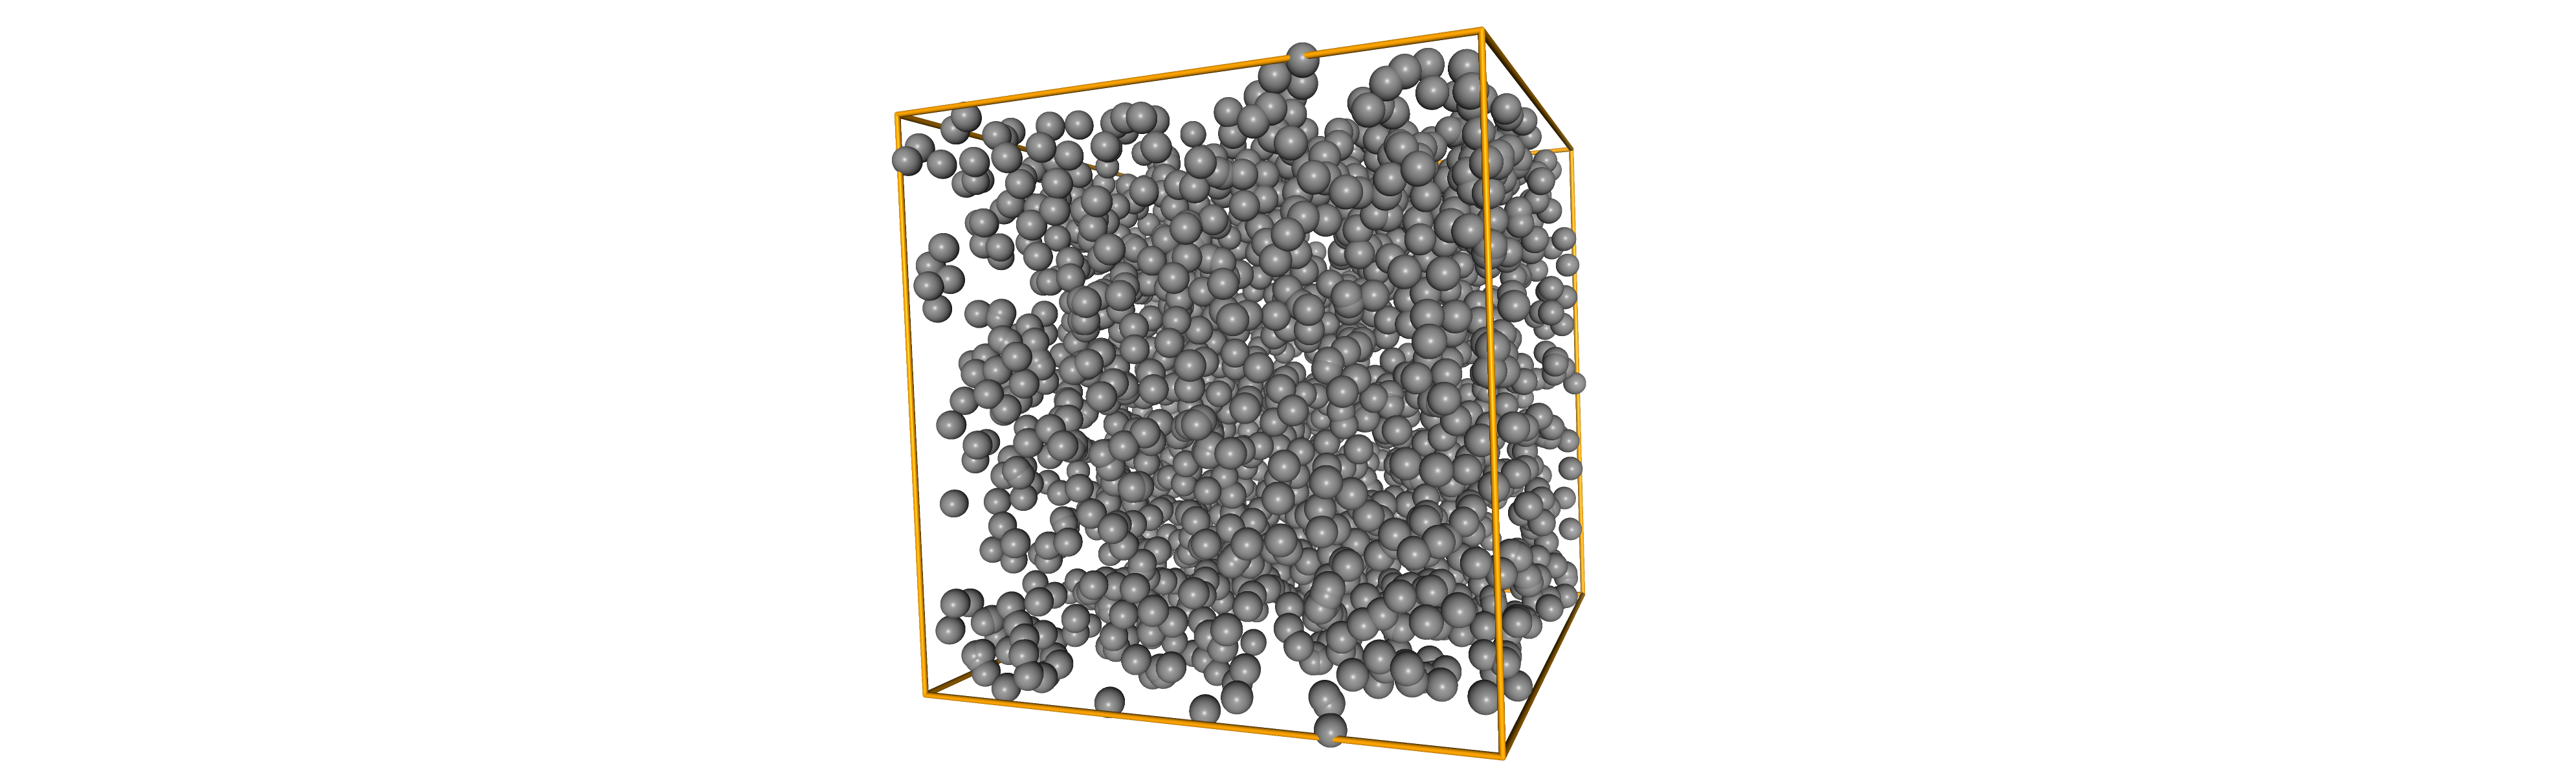

In [112]:
# view.render_image()
view._display_image()

## Methanol PES

Here is an example on how to use LAMMPS in order to compute the energy of 
your system, considering a given methodology (molecular mechanics here) and
a series of molecular structures.

The system consists in a methanol molecule in vacuum and the corresponding
data file is `methanol.data`.

In the following input we simply read this data file and define the force
field. As we will not do any simulation later, Verlet scheme and neighbor list
options are not specified and default values are used. Of course, 
`atom_style` and force fields options must be consistent with the data file.


In [15]:
methanol_inp = """# LAMMPS input file for Methanol

units real
atom_style full
boundary  f f f

bond_style harmonic
angle_style harmonic
dihedral_style opls
pair_style      lj/cut/coul/cut 14

read_data methanol.data

# LJ: OPLS
# energy = kcal/mol
# distance = angstrom
pair_coeff        1        1    0.0660     3.5000
pair_coeff        2        2    0.0300     2.5000
pair_coeff        3        3    0.1700     3.1200
pair_coeff        4        4    0.0000     0.0000
pair_modify shift no mix geometric
special_bonds amber

fix NVE all nve
"""

### One single calculation

Again, we create the `lammps` object. Here we reduce output and redirect 
stdout to `devnull`.

In [16]:
lmp.close()
lmp = lammps.lammps(cmdargs=["-log", "none", "-screen", os.devnull,  "-nocite"])
lmp.commands_string(methanol_inp)

Let's make an energy calculation and output energy quantities.

In [17]:
lmp.command("run 0")

In [18]:
for energy in ["etotal", "evdwl", "ecoul", "ebond", "eangle", "edihed"]:
    print(f"{energy:8s} {lmp.get_thermo(energy):10.4f} kcal.mol-1")

etotal       7.5410 kcal.mol-1
evdwl        0.0000 kcal.mol-1
ecoul        3.1738 kcal.mol-1
ebond        4.2671 kcal.mol-1
eangle       0.1001 kcal.mol-1
edihed       0.0000 kcal.mol-1


It's possible to extract the last (current) geometry of the calculation and reconstruct 
the molecule. Note that, in this particular case, with `run 0` the geometry is the same as the
input one.

Remember also, that in LAMMPS, by default, atoms are not sorted (if you
perform several steps). It is thus safer to get atom ids.

Here we use the numpy property of the lammps object to get numpy arrays 
(more convenient) instead of pointers.

In [19]:
coords = lmp.numpy.extract_atom("x")
print("coords\n", coords)

ids = lmp.numpy.extract_atom("id")
print("atom ids", ids)

i_types = lmp.numpy.extract_atom("type")
print("atom types", i_types)

elements = ["C", "H", "O", "H"]
dict_types = {i: el for i, el in enumerate(elements, 1)}

# TODO: sort by id if needed
print(f"\n{'el':2s} {'id':>4s}{'x':>12s} {'y':>12s} {'z':>12s}")
for iat in range(lmp.get_natoms()):
    specie = dict_types[i_types[iat]]
    xyz = coords[iat]
    line =  f"{specie:2s} {ids[iat]:4d}"
    line += " ".join([f"{x:12.6f}" for x in xyz])
    print(line)

coords
 [[ 0.       0.       0.     ]
 [ 0.63     0.63     0.63   ]
 [-0.63    -0.63     0.63   ]
 [ 0.63    -0.63    -0.63   ]
 [-0.86603  0.86603 -0.86603]
 [-0.28871  1.4434  -1.4434 ]]
atom ids [1 2 3 4 5 6]
atom types [1 2 2 2 3 4]

el   id           x            y            z
C     1    0.000000     0.000000     0.000000
H     2    0.630000     0.630000     0.630000
H     3   -0.630000    -0.630000     0.630000
H     4    0.630000    -0.630000    -0.630000
O     5   -0.866030     0.866030    -0.866030
H     6   -0.288710     1.443400    -1.443400


In [20]:
lmp.close()

### PES calculations

Hereafter, we compute the energy on a series of geometries read from an
xyz file.

First we read the coordinates in the `scan.allxyz` file. It consists in 
73 geometries of methanol along the dihedral angle `H-O-C-H`.

In [21]:
scan_coords = list()
with open("scan.allxyz", "r") as f:
    chunks = f.read().split(">")
    for chunk in chunks:
        lines = chunk.strip().split("\n")
        coords = list()
        for line in lines[2:]:
            coords.append(line.split()[1:])
        scan_coords.append(coords)
scan_coords = np.array(scan_coords, dtype=np.float64)

n_geo, n_atoms, n_dim = scan_coords.shape
print(n_geo, n_atoms, n_dim)

73 6 3


Now, again we initialize the LAMMPS object and load the force fields
information as previously.

In [22]:
lmp.close()
lmp = lammps.lammps(cmdargs=["-log", "none", "-screen", os.devnull,  "-nocite"])
lmp.commands_string(methanol_inp)

We write a loop over the geometries read in the the `scan.allxyz` file. The 
atoms' coordinates are accessible from a pointer by interacting with the current
LAMMPS execution.

Hereafter, we get back the pointer in the `p_coords` variable. Then, in a loop, 
the coordinates are updated and the energy is computed as done previously for 
one single geometry.

Thanks to the default `thermo` variables, for each geometry we store the different
energy components in a dictionary.

In [23]:
# get the pointers on coordinates => used to update geometry
p_coords = lmp.extract_atom("x")

scan_data = list()
dihedral = 0
for step_coords in scan_coords:
    dihedral += 5.0

    # update coordinates
    # p_coords is not a numpy array but a double C pointer
    for iat in range(n_atoms):
        p_coords[iat][0], p_coords[iat][1], p_coords[iat][2] = step_coords[iat]

    # compute energy
    lmp.command("run 0")

    # get back results
    step_data = dict(dihedral=dihedral)
    for energy in ["etotal", "evdwl", "ecoul", "ebond", "eangle", "edihed"]:
        step_data[energy] = lmp.get_thermo(energy)

    scan_data.append(step_data)

In [24]:
lmp.close()

We gather data in a pandas DataFrame in combination with QM energies.

In [25]:
df = pd.DataFrame(scan_data)
df.set_index("dihedral", inplace=True)
df.etotal -= df.etotal.min()
df.head()

etotal  evdwl     ecoul     ebond    eangle    edihed
dihedral                                                         
5.0       0.853286    0.0  3.276409  0.082618  0.205623  1.055928
10.0      0.838037    0.0  3.276421  0.083220  0.207423  1.038266
15.0      0.794073    0.0  3.276481  0.085447  0.212537  0.986901
20.0      0.725481    0.0  3.276334  0.089648  0.221138  0.905654
25.0      0.637719    0.0  3.275813  0.095966  0.233131  0.800102

In [26]:
qm_df = pd.read_csv(
    "scan.qm.dat", 
    index_col=0, 
    delim_whitespace=True, 
    names=["dihedral", "QM"]
)
qm_df -= qm_df.QM.min()
qm_df *= 627.5095  # Hartree -> kcal.mol-1
qm_df.head()

QM
dihedral          
0.0       1.512185
5.0       1.482642
10.0      1.403670
15.0      1.283351
20.0      1.131619

Now depending on what you want to do, you can compare the contributions
of each energy to the total energy and compare them to the QM energy.

Here, in the case of OPLS force field of a dihedral angle, considering
the height of the energy barriers, differences are smaller than the 
expected accuracy.

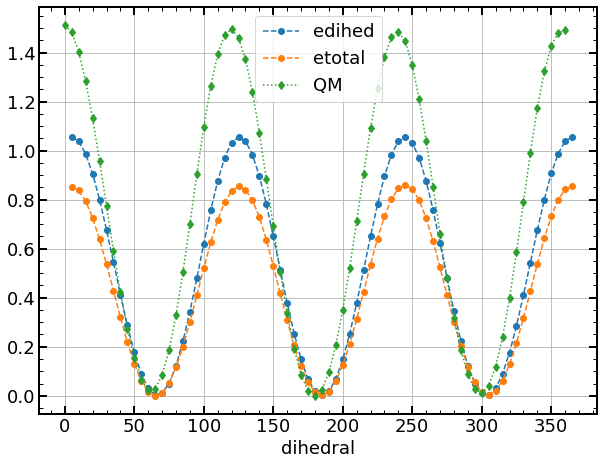

In [27]:
ax = df.plot(y=["edihed", "etotal"], marker="o", ls="--")
ax = qm_df.plot(ax=ax, marker="d", ls=":")